In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib
from tqdm import tqdm
import pickle
import os
import socket
from Bio import Seq, SeqIO


if 'biochem1' in socket.gethostname():
    dataPBase = '/avicenna/vramani/analyses/pacbio/'
    figPBase = '/avicenna/cmcnally/pbanalysis/'
if 'titan' in socket.gethostname():
    dataPBase = '/data/users/goodarzilab/colin/results/pacbio/'
if 'wynton' in socket.gethostname():
    dataPBase = '/wynton/group/goodarzilab/ramanilab/results/pacbio/'
if 'rumi' in socket.gethostname():
    raise Exception('no pacbio results folder on rumi')
    
    
sampleRef = pd.read_csv(dataPBase + 'sampleRef_K562_mESC.csv', sep=',', index_col=0)

sampleRef

In [ ]:
# Merge HMM out files

usesamples = [2,3,6,7,10,11,19,21,23,25,27,0,8,20,28]

for samp in usesamples:
    import glob

    hmmPieces = glob.glob('{0}{1}/processed/binarized/HMMout/{1}_{2}_HMMres_piece*.pickle'.format(dataPBase,
                                                                                                  sampleRef['cell'][samp],
                                                                                                  sampleRef['sampleName'][samp]))
    hmmPieces = sorted(hmmPieces)

    hmmAll = {}

    for piece in tqdm(hmmPieces, position=0):
        with open(piece,'rb') as fopen:
            hmmPart = pickle.load(fopen)
        hmmAll.update(hmmPart)

    with open('{0}{1}/processed/binarized/{1}_{2}_NNsingle_HMM.pickle'.format(dataPBase,
                                                                              sampleRef['cell'][samp],
                                                                              sampleRef['sampleName'][samp]), 'wb') as fout:
        pickle.dump(hmmAll, fout)

## From genomic HMM output, go through and find all inaccessible regions and output them

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib
from tqdm import tqdm
import pickle
import os
import socket


if 'biochem1' in socket.gethostname():
    dataPBase = '/avicenna/vramani/analyses/pacbio/'
    figPBase = '/avicenna/cmcnally/pbanalysis/'
if 'titan' in socket.gethostname():
    dataPBase = '/data/users/goodarzilab/colin/results/pacbio/'
if 'wynton' in socket.gethostname():
    dataPBase = '/wynton/group/goodarzilab/ramanilab/results/pacbio/'
if 'rumi' in socket.gethostname():
    raise Exception('no pacbio results folder on rumi')
    
    
#sampleRef = pd.read_csv(dataPBase + 'sampleRef_K562_mESC.csv', sep=',')
#usesamples = [4,5,8,9,14,15,18,19,20,21,22,23,24,25,26,27]
#usesamples = [30,31,32,33,34,35,36]
#usesamples = [37,38,40,41,42,44,45,46,48]
#usesamples = [12,13,28]
usesamples = [27] #2,3,6,7,10,11,19,21,23,25,27,0,8,20,28 #BrdU set

for samp in usesamples:

    hmmFile = '{0}{1}/processed/binarized/{1}_{2}_NNsingle_HMM.pickle'.format(dataPBase,
                                                                              sampleRef['cell'][samp],
                                                                              sampleRef['sampleName'][samp])
    zmwinfoFile = '{0}{1}/processed/full/{1}_{2}_full_zmwinfo.pickle'.format(dataPBase,
                                                                              sampleRef['cell'][samp],
                                                                              sampleRef['sampleName'][samp])


    zmwinfo = pd.read_pickle(zmwinfoFile)

    with open(hmmFile, 'rb') as fin:
        hmmdat = pickle.load(fin)

    regions = {'zmw':[], 'length':[], 'start':[], 'end':[]}

    for zmw in tqdm(zmwinfo['zmw'], desc=str(samp), position=0, mininterval=1, ncols=80):
        try:
            hmm = hmmdat[zmw]
            goodzmw = True
        except KeyError:
            goodzmw = False
            pass
        
        if goodzmw:
            inacregion = hmm
            inacregion[np.isfinite(inacregion)] = inacregion[np.isfinite(inacregion)] > 0.5

            inacswitch = np.diff(inacregion)
            switchp = np.where(np.logical_or(inacswitch == 1, inacswitch == -1))[0]

            if len(switchp) < 1:
                if hmm[50] == 0: #checking if the entire molecule is inaccessible, 50 being an arbitrary position to check
                    regions['zmw'].append(zmw)
                    regions['length'].append(len(hmm) - 0)
                    regions['start'].append(np.nan)
                    regions['end'].append(np.nan)
                continue

            if inacswitch[switchp[0]] == -1:
                inInacReg = False
                regStart = -1
                regEnd = -1
            if inacswitch[switchp[0]] == 1:
                inInacReg = True
                regStart = np.nan
                regEnd = -1
            for point in switchp:
                if inacswitch[point] == -1 and not inInacReg:
                    inInacReg = True
                    regStart = point + 1
                if inacswitch[point] == 1 and inInacReg:
                    inInacReg = False
                    regEnd = point
                    regions['zmw'].append(zmw)
                    if np.isnan(regStart):
                        regions['length'].append(regEnd - 0)
                    else:
                        regions['length'].append(regEnd - regStart)
                    regions['start'].append(regStart)
                    regions['end'].append(regEnd)
            if inInacReg:
                regions['zmw'].append(zmw)
                regions['length'].append(len(hmm) - regStart)
                regions['start'].append(regStart)
                regions['end'].append(np.nan)
        
        

    regionD = pd.DataFrame(regions)

    if not os.path.exists(dataPBase + '%s/processed/inaccessibleRegions' % (sampleRef['cell'][samp])):
        os.makedirs(dataPBase + '%s/processed/inaccessibleRegions' % (sampleRef['cell'][samp]))

    regionD.to_csv(dataPBase + '{0}/processed/inaccessibleRegions/{0}_{1}_inacRegions.csv'.format(sampleRef['cell'][samp],
                                                                                                  sampleRef['sampleName'][samp]))


## Generate CSV of amplicon HMM results
21/07/16

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib
from tqdm import tqdm
import pickle
import os
import socket


if 'biochem1' in socket.gethostname():
    dataPBase = '/avicenna/vramani/analyses/pacbio/'
    figPBase = '/avicenna/cmcnally/pbanalysis/'
if 'titan' in socket.gethostname():
    dataPBase = '/data/users/goodarzilab/colin/results/pacbio/'
if 'wynton' in socket.gethostname():
    dataPBase = '/wynton/group/goodarzilab/ramanilab/results/pacbio/'
if 'rumi' in socket.gethostname():
    raise Exception('no pacbio results folder on rumi')
    
sampleRef = pd.read_csv(dataPBase + 'pbrun10_CTCFpool_2/pbrun10_CTCFpool_2.sampleReference.csv')
sampleRef = pd.concat([sampleRef,
                       pd.read_csv(dataPBase + 'pbrun10_CTCFpool_1/pbrun10_CTCFpool_1.sampleReference.csv')],
                      ignore_index=True)
sampleRef = pd.concat([sampleRef,
                       pd.read_csv(dataPBase + '210516_NA_SNF2hCTCFarray_ST_rep2/210516_NA_SNF2hCTCFarray_ST_rep2.sampleReference.wynton.csv')],
                      ignore_index=True)
sampleRef = pd.concat([sampleRef,
                       pd.read_csv(dataPBase + '210520_NA_SNF2hCTCFarray_MT_rep1/210520_NA_SNF2hCTCFarray_MT_rep1.sampleReference.wynton.csv')],
                      ignore_index=True)
sampleRef = pd.concat([sampleRef,
                       pd.read_csv(dataPBase + '210608_NA_SNF2hCTCFarray_MT_rep2/210608_NA_SNF2hCTCFarray_MT_rep2.sampleReference.wynton.csv')],
                      ignore_index=True)

del sampleRef['index'] 
    
    
sampleRef =  pd.read_csv(dataPBase + 'pbrun3-9_SampleReference.csv')


for samp in [3, 44, 45, 47, 48, 51, 52]:
    
#for samp in range(sampleRef.shape[0]):

    hmmFile = '{0}{1}/processed/binarized/{1}_{2}_HMM.npy'.format(dataPBase,
                                                                              sampleRef['cell'][samp],
                                                                              sampleRef['sampleName'][samp])
    hmmdat = np.load(hmmFile)

    regions = {'molecule':[], 'length':[], 'start':[], 'end':[]}

    for iz in tqdm(range(hmmdat.shape[0]), desc=str(samp), position=0, mininterval=1):
        hmm = hmmdat[iz,:]

        inacregion = hmm
        inacregion[np.isfinite(inacregion)] = inacregion[np.isfinite(inacregion)] > 0.5

        inacswitch = np.diff(inacregion)
        switchp = np.where(np.logical_or(inacswitch == 1, inacswitch == -1))[0]

        if len(switchp) < 1:
            if hmm[0] == 0:
                regions['molecule'].append(iz)
                regions['length'].append(len(hmm) - 0)
                regions['start'].append(np.nan)
                regions['end'].append(np.nan)
            continue
            
        if inacswitch[switchp[0]] == -1:
            inInacReg = False
            regStart = -1
            regEnd = -1
        if inacswitch[switchp[0]] == 1:
            inInacReg = True
            regStart = np.nan
            regEnd = -1
        for point in switchp:
            if inacswitch[point] == -1 and not inInacReg:
                inInacReg = True
                regStart = point + 1
            if inacswitch[point] == 1 and inInacReg:
                inInacReg = False
                regEnd = point
                regions['molecule'].append(iz)
                if np.isnan(regStart):
                    regions['length'].append(regEnd - 0)
                else:
                    regions['length'].append(regEnd - regStart)
                regions['start'].append(regStart)
                regions['end'].append(regEnd)
        if inInacReg:
            regions['molecule'].append(iz)
            regions['length'].append(len(hmm) - regStart)
            regions['start'].append(regStart)
            regions['end'].append(np.nan)

    regionD = pd.DataFrame(regions)

    if not os.path.exists(dataPBase + '%s/processed/inaccessibleRegions' % (sampleRef['cell'][samp])):
        os.makedirs(dataPBase + '%s/processed/inaccessibleRegions' % (sampleRef['cell'][samp]))

    regionD.to_csv(dataPBase + '{0}/processed/inaccessibleRegions/{0}_{1}_inacRegions.csv'.format(sampleRef['cell'][samp],
                                                                                                  sampleRef['sampleName'][samp]))


## Classify number of nucleosomes in each molecule
21/07/20

In [ ]:
# CTCF sites

# load in reference sequences for both the independent and dependent CTCF sites
refFile = dataPBase + 'pbrun10_CTCFpool_2/snf2h_independent_site_observed.fasta'
for ir, record in enumerate(SeqIO.parse(refFile, 'fasta')):
    if ir > 0:
        raise InputError('Reference fasta has multiple entries')
    irefseq = record.seq # reference sequence for independent CTCF site
refFile = dataPBase + 'pbrun10_CTCFpool_2/snf2h_dependent_site_observed.fasta'
for ir, record in enumerate(SeqIO.parse(refFile, 'fasta')):
    if ir > 0:
        raise InputError('Reference fasta has multiple entries')
    drefseq = record.seq # reference sequence for dependent CTCF site

# Load in the sample reference tables for the CTCF site samples
sampleRef = pd.read_csv(dataPBase + 'pbrun10_CTCFpool_2/pbrun10_CTCFpool_2.sampleReference.csv')
sampleRef = pd.concat([sampleRef,
                       pd.read_csv(dataPBase + 'pbrun10_CTCFpool_1/pbrun10_CTCFpool_1.sampleReference.csv')],
                      ignore_index=True)
sampleRef = pd.concat([sampleRef,
                       pd.read_csv(dataPBase + '210516_NA_SNF2hCTCFarray_ST_rep2/210516_NA_SNF2hCTCFarray_ST_rep2.sampleReference.wynton.csv')],
                      ignore_index=True)
sampleRef = pd.concat([sampleRef,
                       pd.read_csv(dataPBase + '210520_NA_SNF2hCTCFarray_MT_rep1/210520_NA_SNF2hCTCFarray_MT_rep1.sampleReference.wynton.csv')],
                      ignore_index=True)
sampleRef = pd.concat([sampleRef,
                       pd.read_csv(dataPBase + '210608_NA_SNF2hCTCFarray_MT_rep2/210608_NA_SNF2hCTCFarray_MT_rep2.sampleReference.wynton.csv')],
                      ignore_index=True)

del sampleRef['index']

indepSamples = np.nonzero([(name[0:5] == 'Indep' or name[0:8] == 'CTCF_Ind') for name in sampleRef['sampleName']])[0]
depSamples = np.nonzero([(name[0:5] == 'Depen' or name[0:8] == 'CTCF_Dep') for name in sampleRef['sampleName']])[0]

regionAll = pd.DataFrame()
for samp in tqdm(indepSamples[2:], position=0):
    regionFile = dataPBase + '{0}/processed/inaccessibleRegions/{0}_{1}_inacRegions.csv'.format(sampleRef['cell'][samp],
                                                                                                sampleRef['sampleName'][samp])
    regiondf = pd.read_csv(regionFile, index_col=0)

    regiondf['mid'] = regiondf['start'] + (regiondf['end'] - regiondf['start']) / 2
    regiondf['sample'] = samp
    
    regionAll = pd.concat([regionAll, regiondf])
    
regionAllInd = regionAll

regionAll = pd.DataFrame()
for samp in tqdm(depSamples[2:], position=0):
    regionFile = dataPBase + '{0}/processed/inaccessibleRegions/{0}_{1}_inacRegions.csv'.format(sampleRef['cell'][samp],
                                                                                                sampleRef['sampleName'][samp])
    regiondf = pd.read_csv(regionFile, index_col=0)

    regiondf['mid'] = regiondf['start'] + (regiondf['end'] - regiondf['start']) / 2
    regiondf['sample'] = samp
    
    regionAll = pd.concat([regionAll, regiondf])
    
regionAllDep = regionAll

# load in widom
amplicon = 'widom'
sampleRef =  pd.read_csv(dataPBase + 'pbrun3-9_SampleReference.csv')

regionAll = pd.DataFrame()
for samp in tqdm([3, 47, 48, 51, 52], position=0):
    regionFile = dataPBase + '{0}/processed/inaccessibleRegions/{0}_{1}_inacRegions.csv'.format(sampleRef['cell'][samp],
                                                                                                sampleRef['sampleName'][samp])
    regiondf = pd.read_csv(regionFile, index_col=0)

    regiondf['mid'] = regiondf['start'] + (regiondf['end'] - regiondf['start']) / 2
    regiondf['sample'] = samp
    
    regionAll = pd.concat([regionAll, regiondf])
    
regionAllWidom = regionAll

sampleRef = pd.read_csv(dataPBase + 'sampleRef_K562_mESC.csv', sep=',')

regionAll = pd.DataFrame()
for samp in tqdm([4,5,8,9,14,15,18,19,20,21,22,23,24,25,26,27], position=0):
    regionFile = dataPBase + '{0}/processed/inaccessibleRegions/{0}_{1}_inacRegions.csv'.format(sampleRef['cell'][samp],
                                                                                                sampleRef['sampleName'][samp])
    regiondf = pd.read_csv(regionFile, index_col=0)

    regiondf['mid'] = regiondf['start'] + (regiondf['end'] - regiondf['start']) / 2
    regiondf['sample'] = samp
    
    regionAll = pd.concat([regionAll, regiondf])
    
regionAllmESC = regionAll

In [ ]:
from scipy.signal import find_peaks

regiondf = {'widom':regionAllWidom['length'][np.isin(regionAllWidom['sample'], [3, 48, 52])],
            'ind':regionAllInd['length'],
            'dep':regionAllDep['length']}#,
            #'all':regionAllAll['length'],
            #'mesc':regionAllmESC['length']}

molecule = 'ind'

hist, bine = np.histogram(regiondf[molecule], bins=np.arange(-0.5, 2300.5))
binc = bine[0:-1] + 0.5

hist = hist.astype('float')
ix = 0
while hist[ix] == 0:
    hist[ix] = np.nan
    ix += 1
    
smWidth = 21
smWidthH = int((smWidth-1) / 2)
smooths = []

def smooth1time(inp):
    smoothlast = inp.copy()
    smoothn = inp.copy()
    for windc in np.arange(0,2300)[np.isfinite(inp)]:
        windlow = max(0, windc - smWidthH)
        windhigh = min(2300, windc + smWidthH)
        smoothn[windc] = np.nanmean(smoothlast[windlow:windhigh])
    return smoothn

smoothc = hist.copy()
for i in range(10):
    smoothc = smooth1time(smoothc)
    smooths.append(smoothc)

fig, ax = plt.subplots(6,1, figsize=(7,8))
ax[0].plot(np.log10(hist))
for i in range(5):
    ax[i+1].plot(np.log10(smooths[i]))

Text(0.5, 1.0, 'independent CTCF site')

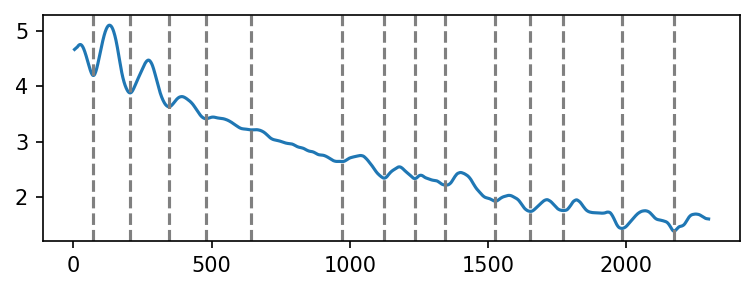

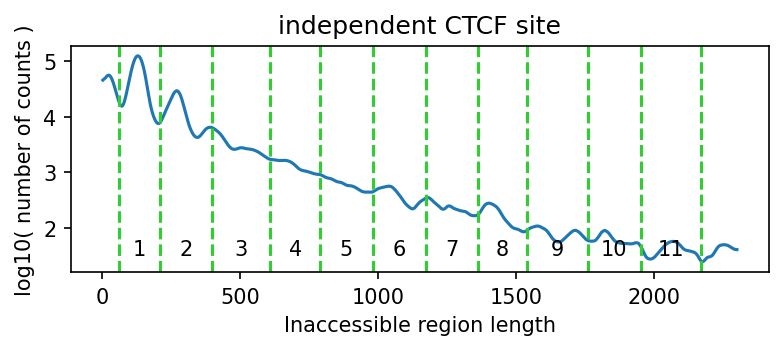

In [13]:
# manually place the divisions between nucleosome counts

usesm = smooths[2]
plt.figure(figsize=(6,2))
plt.plot(binc, np.log10(usesm))
peaks, peakprop = find_peaks(-1 * np.log10(usesm[4:]), width=10, distance=80)
for p in peaks:
    plt.axvline(x=binc[p+4], ls='--', color='gray')
    
divs = [67, 207, 350, 480, 610, 750, 885, 980, 1130]
divsmesc = [50, 200, 370, 500, 630, 800, 970, 1090, 1200]
divswidom = [64, 210, 400, 610, 790, 980, 1175, 1360, 1540, 1760, 1950, 2170]
divsind = [70, 205, 340, 475, 610, 780, 950, 1120, 1300, 1500, 1650, 1770, 1980, 2170, 2350, 2520, 2660]
divsdep = [70, 205, 345, 470, 605, 740, 880, 1005, 1175, 1320, 1500, 1740, 1890, 2035, 2180, 2310, 2480, 2740, 2870, 3000]
plt.figure(figsize=(6,2))
plt.plot(binc, np.log10(usesm))
usedivs = divswidom
for p in usedivs:
    plt.axvline(x=p, ls='--', color='limegreen')
for i in range(len(usedivs)-1):
    midp = usedivs[i] + (usedivs[i+1] - usedivs[i])/2
    plt.text(y=1.5, x=midp, s=str(i+1), ha='center')
plt.xlabel('Inaccessible region length')
plt.ylabel('log10( number of counts )')
plt.title('independent CTCF site')

In [ ]:
# generate output for mESC

molecule = 'mESC'

if molecule == 'mESC':
    divsmesc = np.array([50, 200, 370, 500, 630, 800, 970, 1090, 1200])
    sampleRef = pd.read_csv(dataPBase + 'sampleRef_K562_mESC.csv', sep=',')
    #usesamples = [4,5,8,9,14,15,18,19,20,21,22,23,24,25,26,27]
    #usesamples = [30,31,32,33,34,35,36]
    usesamples = [37,38,40,41,42,44,45,46,48]


#usesamples = [18]
for samp in tqdm(usesamples, position=0):

    zmwinfoFile = '{0}{1}/processed/full/{1}_{2}_full_zmwinfo.pickle'.format(dataPBase,
                                                                              sampleRef['cell'][samp],
                                                                              sampleRef['sampleName'][samp])


    zmwinfo = pd.read_pickle(zmwinfoFile)
    zmwinfo.set_index('zmw', inplace=True)
    zmwinfo.drop_duplicates(inplace=True) # remove duplicate entries
    hmmFile = '{0}{1}/processed/binarized/{1}_{2}_NNsingle_HMM.pickle'.format(dataPBase,
                                                                  sampleRef['cell'][samp],
                                                                  sampleRef['sampleName'][samp])
    with open(hmmFile, 'rb') as fin:
        hmmdat = pickle.load(fin)

    regionFile = dataPBase + '{0}/processed/inaccessibleRegions/{0}_{1}_inacRegions.csv'.format(sampleRef['cell'][samp],
                                                                                                    sampleRef['sampleName'][samp])
    regiondf = pd.read_csv(regionFile, index_col=0)



    densityD = {'zmw':[], 'numRegions':[], 'nucs':[], 'subnucs':[], 'moleculeLength':[], 'calledLength':[], 'fracInaccessible':[], 'overnucs':[]}

    doneZMW = []
    curZMW = None
    for ir in np.arange(regiondf.shape[0]):
        if regiondf['zmw'][ir] != curZMW:
            if curZMW is not None:
                curNs = np.array(curNs)
                densityD['zmw'].append(curZMW)
                doneZMW.append(curZMW)
                densityD['subnucs'].append(np.sum(curNs == 0))
                densityD['overnucs'].append(np.sum(curNs == 9))
                densityD['numRegions'].append(len(curNs))
                densityD['nucs'].append(np.sum(curNs[curNs < 9]))
                densityD['moleculeLength'].append(zmwinfo['cclen'][curZMW])

                hmm = hmmdat[curZMW]
                densityD['calledLength'].append(np.sum(np.isfinite(hmm)))
                inacregion = hmm
                inacregion[np.isfinite(inacregion)] = inacregion[np.isfinite(inacregion)] > 0.5
                densityD['fracInaccessible'].append(np.sum(inacregion == 0) / np.sum(np.isfinite(inacregion)))

            curZMW = regiondf['zmw'][ir]
            curNs = []
        thislength = regiondf['length'][ir]
        thisnucs = np.sum(thislength > divsmesc)
        curNs.append(thisnucs)
    # now do last molecule
    curNs = np.array(curNs)
    densityD['zmw'].append(curZMW)
    doneZMW.append(curZMW)
    densityD['subnucs'].append(np.sum(curNs == 0))
    densityD['overnucs'].append(np.sum(curNs == 9))
    densityD['numRegions'].append(len(curNs))
    densityD['nucs'].append(np.sum(curNs[curNs < 9]))
    densityD['moleculeLength'].append(zmwinfo['cclen'][curZMW])

    hmm = hmmdat[curZMW]
    densityD['calledLength'].append(np.sum(np.isfinite(hmm)))
    inacregion = hmm
    inacregion[np.isfinite(inacregion)] = inacregion[np.isfinite(inacregion)] > 0.5
    densityD['fracInaccessible'].append(np.sum(inacregion == 0) / np.sum(np.isfinite(inacregion)))
                
    # add any missing molecules that had zero inaccessible regions
    doneZMW = np.array(doneZMW)
    allzmw = np.array(list(hmmdat.keys())) #zmwinfo.index.to_numpy()
    missingZMW = allzmw[~np.isin(allzmw, doneZMW)]
    for uzmw in missingZMW:
        densityD['zmw'].append(uzmw)
        densityD['subnucs'].append(0)
        densityD['overnucs'].append(0)
        densityD['numRegions'].append(0)
        densityD['nucs'].append(0)
        densityD['moleculeLength'].append(zmwinfo['cclen'][uzmw])

        hmm = hmmdat[uzmw]
        densityD['calledLength'].append(np.sum(np.isfinite(hmm)))
        inacregion = hmm
        inacregion[np.isfinite(inacregion)] = inacregion[np.isfinite(inacregion)] > 0.5
        densityD['fracInaccessible'].append(np.sum(inacregion == 0) / np.sum(np.isfinite(inacregion)))
        
    densityDF = pd.DataFrame(densityD)
    densityDF.set_index('zmw', inplace=True)
    densityDF.sort_index(axis='index', inplace=True)
    
    if not os.path.exists(dataPBase + '%s/processed/density' % (sampleRef['cell'][samp])):
            os.makedirs(dataPBase + '%s/processed/density' % (sampleRef['cell'][samp]))

    densityFile = dataPBase + '{0}/processed/density/{0}_{1}_density.csv'.format(sampleRef['cell'][samp],
                                                                                                    sampleRef['sampleName'][samp])
    densityDF.to_csv(densityFile)

In [63]:
# generate output for amplicons
molecule = 'ind'

if molecule == 'widom':
    divswidom = [64, 210, 400, 610, 790, 980, 1175, 1360, 1540, 1760, 1950, 2170]
    usedivs = divswidom
    sampleRef =  pd.read_csv(dataPBase + 'pbrun3-9_SampleReference.csv')
    usesamples = [3, 47, 48, 51, 52]
    refLength = 2268
if molecule == 'ind':
    divsind = [70, 205, 340, 475, 610, 780, 950, 1120, 1300, 1500, 1650, 1770, 1980, 2170, 2350, 2520, 2660]
    usedivs = divsind
    sampleRef = pd.read_csv(dataPBase + 'pbrun10_CTCFpool_2/pbrun10_CTCFpool_2.sampleReference.csv')
    sampleRef = pd.concat([sampleRef,
                           pd.read_csv(dataPBase + 'pbrun10_CTCFpool_1/pbrun10_CTCFpool_1.sampleReference.csv')],
                          ignore_index=True)
    sampleRef = pd.concat([sampleRef,
                           pd.read_csv(dataPBase + '210516_NA_SNF2hCTCFarray_ST_rep2/210516_NA_SNF2hCTCFarray_ST_rep2.sampleReference.wynton.csv')],
                          ignore_index=True)
    sampleRef = pd.concat([sampleRef,
                           pd.read_csv(dataPBase + '210520_NA_SNF2hCTCFarray_MT_rep1/210520_NA_SNF2hCTCFarray_MT_rep1.sampleReference.wynton.csv')],
                          ignore_index=True)
    sampleRef = pd.concat([sampleRef,
                           pd.read_csv(dataPBase + '210608_NA_SNF2hCTCFarray_MT_rep2/210608_NA_SNF2hCTCFarray_MT_rep2.sampleReference.wynton.csv')],
                          ignore_index=True)
    del sampleRef['index']
    indepSamples = np.nonzero([(name[0:5] == 'Indep' or name[0:8] == 'CTCF_Ind') for name in sampleRef['sampleName']])[0]
    usesamples = indepSamples[2:]
    refLength = 2706
    
elif molecule == 'dep':
    divsdep = [70, 205, 345, 470, 605, 740, 880, 1005, 1175, 1320, 1500, 1740, 1890, 2035, 2180, 2310, 2480, 2740, 2870, 3000]
    usedivs = divsdep
    refLength = 3087
    sampleRef = pd.read_csv(dataPBase + 'pbrun10_CTCFpool_2/pbrun10_CTCFpool_2.sampleReference.csv')
    sampleRef = pd.concat([sampleRef,
                           pd.read_csv(dataPBase + 'pbrun10_CTCFpool_1/pbrun10_CTCFpool_1.sampleReference.csv')],
                          ignore_index=True)
    sampleRef = pd.concat([sampleRef,
                           pd.read_csv(dataPBase + '210516_NA_SNF2hCTCFarray_ST_rep2/210516_NA_SNF2hCTCFarray_ST_rep2.sampleReference.wynton.csv')],
                          ignore_index=True)
    sampleRef = pd.concat([sampleRef,
                           pd.read_csv(dataPBase + '210520_NA_SNF2hCTCFarray_MT_rep1/210520_NA_SNF2hCTCFarray_MT_rep1.sampleReference.wynton.csv')],
                          ignore_index=True)
    sampleRef = pd.concat([sampleRef,
                           pd.read_csv(dataPBase + '210608_NA_SNF2hCTCFarray_MT_rep2/210608_NA_SNF2hCTCFarray_MT_rep2.sampleReference.wynton.csv')],
                          ignore_index=True)
    del sampleRef['index']
    depSamples = np.nonzero([(name[0:5] == 'Depen' or name[0:8] == 'CTCF_Dep') for name in sampleRef['sampleName']])[0]
    usesamples = depSamples[2:]

for samp in tqdm(usesamples, position=0):

    hmmFile = '{0}{1}/processed/binarized/{1}_{2}_HMM.npy'.format(dataPBase,
                                                                  sampleRef['cell'][samp],
                                                                  sampleRef['sampleName'][samp])
    hmmdat = np.load(hmmFile)

    regionFile = dataPBase + '{0}/processed/inaccessibleRegions/{0}_{1}_inacRegions.csv'.format(sampleRef['cell'][samp],
                                                                                                    sampleRef['sampleName'][samp])
    regiondf = pd.read_csv(regionFile, index_col=0)



    densityD = {'molecule':[], 'numRegions':[], 'nucs':[], 'subnucs':[], 'moleculeLength':[], 'calledLength':[], 'fracInaccessible':[], 'overnucs':[]}

    moleculeDone = np.zeros(hmmdat.shape[0], dtype='int')
    curMol = None
    for ir in np.arange(regiondf.shape[0]):
        if regiondf['molecule'][ir] != curMol:
            if curMol is not None:
                curNs = np.array(curNs)
                densityD['molecule'].append(curMol)
                moleculeDone[curMol] = 1
                densityD['subnucs'].append(np.sum(curNs == 0))
                densityD['overnucs'].append(np.sum(curNs == len(usedivs)))
                densityD['numRegions'].append(len(curNs))
                densityD['nucs'].append(np.sum(curNs))
                densityD['moleculeLength'].append(refLength)

                hmm = hmmdat[curMol,:]
                densityD['calledLength'].append(np.sum(np.isfinite(hmm)))
                inacregion = hmm
                inacregion[np.isfinite(inacregion)] = inacregion[np.isfinite(inacregion)] > 0.5
                densityD['fracInaccessible'].append(np.sum(inacregion == 0) / np.sum(np.isfinite(inacregion)))

            curMol = regiondf['molecule'][ir]
            curNs = []
        thislength = regiondf['length'][ir]
        thisnucs = np.sum(thislength > usedivs)
        curNs.append(thisnucs)
    # now do last molecule
    curNs = np.array(curNs)
    densityD['molecule'].append(curMol)
    moleculeDone[curMol] = 1
    densityD['subnucs'].append(np.sum(curNs == 0))
    densityD['overnucs'].append(np.sum(curNs == len(usedivs)))
    densityD['numRegions'].append(len(curNs))
    densityD['nucs'].append(np.sum(curNs))
    densityD['moleculeLength'].append(refLength)

    hmm = hmmdat[curMol,:]
    densityD['calledLength'].append(np.sum(np.isfinite(hmm)))
    inacregion = hmm
    inacregion[np.isfinite(inacregion)] = inacregion[np.isfinite(inacregion)] > 0.5
    densityD['fracInaccessible'].append(np.sum(inacregion == 0) / np.sum(np.isfinite(inacregion)))
    
    undoneMol = np.nonzero(moleculeDone == 0)[0]
    for umol in undoneMol:
        densityD['molecule'].append(umol)
        densityD['subnucs'].append(0)
        densityD['overnucs'].append(0)
        densityD['numRegions'].append(0)
        densityD['nucs'].append(0)
        densityD['moleculeLength'].append(refLength)
        
        hmm = hmmdat[umol,:]
        densityD['calledLength'].append(np.sum(np.isfinite(hmm)))
        inacregion = hmm
        inacregion[np.isfinite(inacregion)] = inacregion[np.isfinite(inacregion)] > 0.5
        densityD['fracInaccessible'].append(np.sum(inacregion == 0) / np.sum(np.isfinite(inacregion)))
                
    densityDF = pd.DataFrame(densityD)
    densityDF.set_index('molecule', inplace=True)
    densityDF.sort_index(axis='index', inplace=True)

    if not os.path.exists(dataPBase + '%s/processed/density' % (sampleRef['cell'][samp])):
            os.makedirs(dataPBase + '%s/processed/density' % (sampleRef['cell'][samp]))

    densityFile = dataPBase + '{0}/processed/density/{0}_{1}_density.csv'.format(sampleRef['cell'][samp],
                                                                                                    sampleRef['sampleName'][samp])
    densityDF.to_csv(densityFile)
    
    if densityDF.shape[0] != hmmdat.shape[0]:
        print('Mismatch in sample %d, %d vs %d' % (samp, densityDF.shape[0], hmmdat.shape[0]))

100%|██████████| 44/44 [19:42<00:00, 26.88s/it]


## Make condensed representations of HMM output for smaller file size, easier upload to repository
21/12/1

In [ ]:
stateName = {np.nan:'N', 1:'A', 0:'I'}

def hmmPathToString(hmmbin):
    hmmbin[np.isfinite(hmmbin)] = hmmbin[np.isfinite(hmmbin)] > 0.5

    nanse = np.where(np.diff(np.isfinite(hmmbin)))[0]

    inacswitch = np.diff(hmmbin)
    switchp = np.where(np.abs(inacswitch) == 1)[0]

    g = np.concatenate([[0], nanse[0:1]+1, switchp+1, nanse[1:2]+1, [hmmbin.shape[0]]])
    gdif = np.diff(g)

    thisstr = ''
    for ib, b in enumerate(g[0:-1]):
        if ib == 0 or ib == (len(g)-2):
            thisstr += str(gdif[ib]) + 'N'
        else:
            thisstr += str(gdif[ib]) + stateName[hmmbin[b]]
    
    return(thisstr)


for samp in np.arange(4,49):

    hmmFile = '{0}{1}/processed/binarized/{1}_{2}_NNsingle_HMM.pickle'.format(dataPBase,
                                                                              sampleRef['cell'][samp],
                                                                              sampleRef['sampleName'][samp])
    try:
        with open(hmmFile, 'rb') as fin:
            hmmdat = pickle.load(fin)

        zmwlist = list(hmmdat.keys())
        zmwlist.sort()

        outFile = '{0}{1}/processed/binarized/{1}_{2}_HMM_short.csv'.format(dataPBase,
                                                                            sampleRef['cell'][samp],
                                                                            sampleRef['sampleName'][samp])

        with open(outFile, 'w') as fout:
            for zmw in tqdm(zmwlist, position=0, ncols=100, desc=sampleRef['cell'][samp]+'_'+sampleRef['sampleName'][samp]):
                fout.write('{0},{1}\n'.format(zmw, hmmPathToString(hmmdat[zmw])))
    
    except FileNotFoundError:
        continue


In [ ]:
# now do the same for S1 and S2 results

stateName = {1:'A', 0:'I'}

def hmmPathToString(hmmbin):
    hmmbin[np.isfinite(hmmbin)] = hmmbin[np.isfinite(hmmbin)] > 0.5

    inacswitch = np.diff(hmmbin)
    switchp = np.where(np.abs(inacswitch) == 1)[0]

    g = np.concatenate([[0], switchp+1, [hmmbin.shape[0]]])
    gdif = np.diff(g)

    thisstr = ''
    for ib, b in enumerate(g[0:-1]):
        thisstr += str(gdif[ib]) + stateName[hmmbin[b]]
    
    return(thisstr)

sampleRef = pd.read_csv(dataPBase + 'pbrun10_CTCFpool_2/pbrun10_CTCFpool_2.sampleReference.csv')
sampleRef = pd.concat([sampleRef,
                       pd.read_csv(dataPBase + 'pbrun10_CTCFpool_1/pbrun10_CTCFpool_1.sampleReference.csv')],
                      ignore_index=True)
sampleRef = pd.concat([sampleRef,
                       pd.read_csv(dataPBase + '210516_NA_SNF2hCTCFarray_ST_rep2/210516_NA_SNF2hCTCFarray_ST_rep2.sampleReference.wynton.csv')],
                      ignore_index=True)
sampleRef = pd.concat([sampleRef,
                       pd.read_csv(dataPBase + '210520_NA_SNF2hCTCFarray_MT_rep1/210520_NA_SNF2hCTCFarray_MT_rep1.sampleReference.wynton.csv')],
                      ignore_index=True)
sampleRef = pd.concat([sampleRef,
                       pd.read_csv(dataPBase + '210608_NA_SNF2hCTCFarray_MT_rep2/210608_NA_SNF2hCTCFarray_MT_rep2.sampleReference.wynton.csv')],
                      ignore_index=True)

del sampleRef['index'] 

for samp in np.arange(sampleRef.shape[0]):

    hmmFile = '{0}{1}/processed/binarized/{1}_{2}_HMM.npy'.format(dataPBase,
                                                                  sampleRef['cell'][samp],
                                                                  sampleRef['sampleName'][samp])
    try:
        hmmdat = np.load(hmmFile)

        outFile = '{0}{1}/processed/binarized/{1}_{2}_HMM_short.csv'.format(dataPBase,
                                                                            sampleRef['cell'][samp],
                                                                            sampleRef['sampleName'][samp])

        with open(outFile, 'w') as fout:
            for iz in tqdm(np.arange(hmmdat.shape[0]), position=0, ncols=120,
                           desc=sampleRef['cell'][samp]+'_'+sampleRef['sampleName'][samp]):
                fout.write('{0},{1}\n'.format(iz, hmmPathToString(hmmdat[iz,:])))
    
    except FileNotFoundError:
        continue


## Gather files for Zenodo repository
21/12/08

In [ ]:
import os
from shutil import copy2
import pandas as pd
import numpy as np
import socket

if 'biochem1' in socket.gethostname():
    dataPBase = '/avicenna/vramani/analyses/pacbio/'
    
zdir = '/avicenna/cmcnally/zenodo_repository'
if not os.path.exists(zdir):
    os.makedirs(zdir)

for subdir in ['S1', 'S2', 'mESC']:
    if not os.path.exists(zdir + '/' + subdir):
        os.makedirs(zdir + '/' + subdir)

        
# copy over S1 and S2 first ===============================================================

# Load in the sample reference tables for the CTCF site samples
sampleRef = pd.read_csv(dataPBase + 'pbrun10_CTCFpool_2/pbrun10_CTCFpool_2.sampleReference.csv')
sampleRef = pd.concat([sampleRef,
                       pd.read_csv(dataPBase + 'pbrun10_CTCFpool_1/pbrun10_CTCFpool_1.sampleReference.csv')],
                      ignore_index=True)
sampleRef = pd.concat([sampleRef,
                       pd.read_csv(dataPBase + '210516_NA_SNF2hCTCFarray_ST_rep2/210516_NA_SNF2hCTCFarray_ST_rep2.sampleReference.wynton.csv')],
                      ignore_index=True)
sampleRef = pd.concat([sampleRef,
                       pd.read_csv(dataPBase + '210520_NA_SNF2hCTCFarray_MT_rep1/210520_NA_SNF2hCTCFarray_MT_rep1.sampleReference.wynton.csv')],
                      ignore_index=True)
sampleRef = pd.concat([sampleRef,
                       pd.read_csv(dataPBase + '210608_NA_SNF2hCTCFarray_MT_rep2/210608_NA_SNF2hCTCFarray_MT_rep2.sampleReference.wynton.csv')],
                      ignore_index=True)

del sampleRef['index']

indepSamples = np.nonzero([(name[0:5] == 'Indep' or name[0:8] == 'CTCF_Ind') for name in sampleRef['sampleName']])[0]
depSamples = np.nonzero([(name[0:5] == 'Depen' or name[0:8] == 'CTCF_Dep') for name in sampleRef['sampleName']])[0]

subdirs = ['S1', 'S2']
samplesets = [indepSamples, depSamples]
for i in range(2):
    subdir = subdirs[i]
    sampset = samplesets[i]
    HMMpath = os.path.join(zdir, subdir, 'accessibilityPath')
    Densitypath = os.path.join(zdir, subdir, 'density')
    if not os.path.exists(HMMpath):
        os.makedirs(HMMpath)
    if not os.path.exists(Densitypath):
        os.makedirs(Densitypath)
    
    for samp in sampset:
        try:
            copy2('{0}{1}/processed/binarized/{1}_{2}_HMM_short.csv'.format(dataPBase,
                                                                            sampleRef['cell'][samp],
                                                                            sampleRef['sampleName'][samp]),
                  HMMpath)
        except FileNotFoundError:
            continue
        
        try:
            copy2('{0}{1}/processed/density/{1}_{2}_density.csv'.format(dataPBase,
                                                                        sampleRef['cell'][samp],
                                                                        sampleRef['sampleName'][samp]),
                  Densitypath)
        except FileNotFoundError:
            continue
    
copy2('{0}{1}/snf2h_independent_site_observed.fasta'.format(dataPBase,'pbrun10_CTCFpool_2'),
      os.path.join(zdir, 'S1', 'S1_reference.fasta'))
copy2('{0}{1}/snf2h_dependent_site_observed.fasta'.format(dataPBase,'pbrun10_CTCFpool_2'),
      os.path.join(zdir, 'S2', 'S2_reference.fasta'))

copy2('/avicenna/cmcnally/code/scripts/expandAccessibilityAmplicon.py', os.path.join(zdir, 'S1'))
copy2('/avicenna/cmcnally/code/scripts/expandAccessibilityAmplicon.py', os.path.join(zdir, 'S2'))



In [ ]:
subdir = 'mESC'
HMMpath = os.path.join(zdir, subdir, 'accessibilityPath')
DensityPath = os.path.join(zdir, subdir, 'density')
if not os.path.exists(HMMpath):
    os.makedirs(HMMpath)
if not os.path.exists(DensityPath):
    os.makedirs(DensityPath)
AlignPath = os.path.join(zdir, subdir, 'alignments')
if not os.path.exists(AlignPath):
    os.makedirs(AlignPath)
    
sampleRef = pd.read_csv(dataPBase + 'sampleRef_K562_mESC.csv', sep=',', index_col=0)

for samp in range(sampleRef.shape[0]):
    if 'ATP' in sampleRef['sampleName'][samp]:
        continue
    try:
        copy2('{0}{1}/processed/binarized/{1}_{2}_HMM_short.csv'.format(dataPBase,
                                                                        sampleRef['cell'][samp],
                                                                        sampleRef['sampleName'][samp]),
              HMMpath)
    except FileNotFoundError:
        continue
        
    try:
        copy2('{0}{1}/processed/density/{1}_{2}_density.csv'.format(dataPBase,
                                                                    sampleRef['cell'][samp],
                                                                    sampleRef['sampleName'][samp]),
              DensityPath)
    except FileNotFoundError:
        continue
        
    try:
        copy2('{0}{1}/aligned/{1}.split.{2}.ccs.aligned.sorted.bam'.format(dataPBase,
                                                                           sampleRef['cell'][samp],
                                                                           sampleRef['sampleName'][samp]),
              AlignPath)
    except FileNotFoundError:
        continue
        
copy2('/avicenna/cmcnally/code/scripts/expandAccessibilityGenomic.py', os.path.join(zdir, 'mESC'))